In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import defaultdict
import torchvision.transforms as transforms
from PIL import Image

from config import *
from dataset import *
from model import CNNModel
from utils import *

In [2]:
set_seed(42)
device = get_device()
model = CNNModel()
model = load_model(model)

conv_weights = [] 
conv_layers = [] 
for module in model.children():
    if isinstance(module, nn.Conv2d):
        conv_weights.append(module.weight)
        conv_layers.append(module)

Model loaded


In [3]:
set_seed(42)
test_dataset = CustomImageFolder(root=args.test_dir)
test_dataset = TransformedDataset(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
label_dict = {0:"breed9", 1:"breed28", 2:"breed41", 3:"other"}
label_set = set()
samples_per_label = defaultdict(list)

samples_per_class = 3 
# Sample 3 images per breed
for i, (image, label, breed) in enumerate(test_loader):
    label = label.item()
    if len(samples_per_label[label]) < samples_per_class:
        samples_per_label[label].append((image, label, breed[0])) 

    # Stop when each label has enough samples
    if len(samples_per_label) == len(label_dict) and all(len(images) >= samples_per_class for images in samples_per_label.values()):
        break

# Sort samples
sample_breed = sorted(
    [sample for samples in samples_per_label.values() for sample in samples],
    key=lambda x: x[1]
)

In [4]:
all_labels = [item[1] for item in sample_breed]
all_labels

all_image = [item[-1] for item in sample_breed]
all_image

['../data/assignment_test/breed9/j_0001_375.png',
 '../data/assignment_test/breed9/v_0035_356.png',
 '../data/assignment_test/breed9/v_0035_283.png',
 '../data/assignment_test/breed28/h_0030_496.png',
 '../data/assignment_test/breed28/c_0011_261.png',
 '../data/assignment_test/breed28/k_0025_19.png',
 '../data/assignment_test/breed41/y_0033_197.png',
 '../data/assignment_test/breed41/o_0057_527.png',
 '../data/assignment_test/breed41/bw_0026_435.png',
 '../data/assignment_test/breed39/a_0007_250.png',
 '../data/assignment_test/breed25/a_0041_79.png',
 '../data/assignment_test/breed16/a_0004_288.png']

In [14]:
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    for i, (images, labels, path) in enumerate(sample_breed):
        labels = torch.tensor(labels)
        images, labels = images.to(device), labels.to(device)
        outputs=model(images)
        _, predictions = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(predictions==labels.data))
        print(f"{path=}")
        print(f"Labels: {labels.tolist()}, Predictions: {predictions.tolist()[-1]}")
test_accuracy = test_accuracy/len(sample_breed)
test_accuracy

path='../data/assignment_test/breed9/j_0001_375.png'
Labels: 0, Predictions: 3
path='../data/assignment_test/breed9/v_0035_356.png'
Labels: 0, Predictions: 3
path='../data/assignment_test/breed9/v_0035_283.png'
Labels: 0, Predictions: 3
path='../data/assignment_test/breed28/h_0030_496.png'
Labels: 1, Predictions: 3
path='../data/assignment_test/breed28/c_0011_261.png'
Labels: 1, Predictions: 3
path='../data/assignment_test/breed28/k_0025_19.png'
Labels: 1, Predictions: 3
path='../data/assignment_test/breed41/y_0033_197.png'
Labels: 2, Predictions: 3
path='../data/assignment_test/breed41/o_0057_527.png'
Labels: 2, Predictions: 3
path='../data/assignment_test/breed41/bw_0026_435.png'
Labels: 2, Predictions: 3
path='../data/assignment_test/breed39/a_0007_250.png'
Labels: 3, Predictions: 3
path='../data/assignment_test/breed25/a_0041_79.png'
Labels: 3, Predictions: 3
path='../data/assignment_test/breed16/a_0004_288.png'
Labels: 3, Predictions: 3


0.25

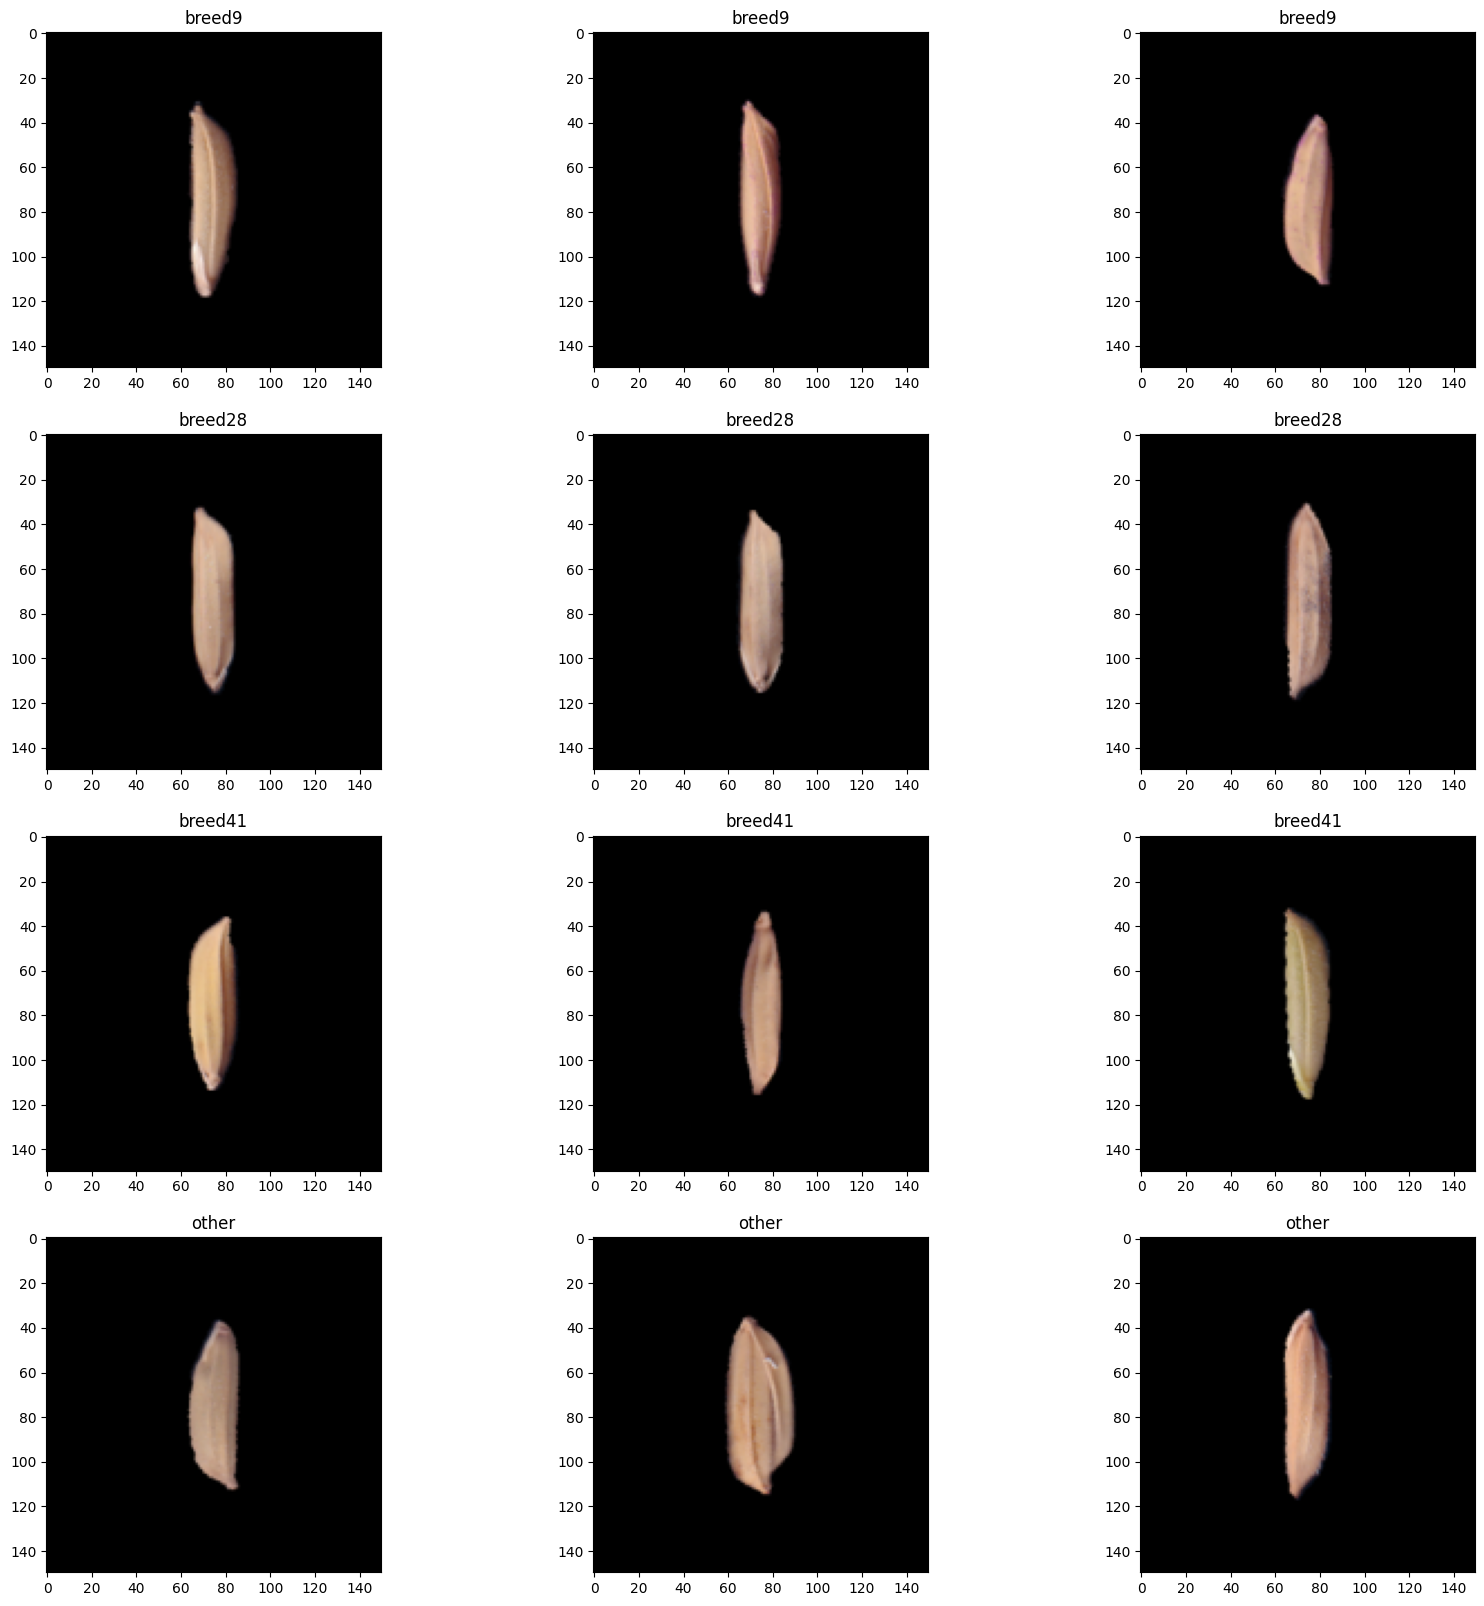

In [16]:
plt.figure(figsize=(20, 20))
for i, (image, label, breed) in enumerate(sample_breed):
    image = (image * 0.5 + 0.5).clip(0, 1).squeeze(0).permute(1,2,0).cpu().numpy()
    plt.subplot(4, 3, i+1)
    plt.imshow(image)
    plt.title(f"{label_dict[label]}")